# **CHL5230 Datathon 1 - Team 13**

**Topic: Public Health Factors Influencing BMI**

**Team Members:** Gemma Postill, Rebecca Lee, Jack Li

---

**Research Question**

1. Are there distinct subtypes of obesity influenced by lifestyle factors?
2. What modifiable risk factors of obesity are present within each subtype, identifying groups for targeted public health intervention?

---

**Analysis Plan**

To determine how risk factors of BMI cluster together and create distinct obesity phenotypes, we will use unsupervised machine learning.

- Filter data to only include BMI ≥ 30.0 (obese)
- Remove non-modifiable factors influencing BMI (age, gender)
- Use KMeans clustering and determine optimal number of clusters using elbow method.
- Split the data into testing and training to develop and evaluate our model.
- Use F1 scores, recall, and precision to evaluate how our clusters perform on the testing data.
- Conduct a descriptive analysis of the clusters to determine the modifiable and non-modifiable risk factors within each group.


In [ ]:
## Uploading the Data

import pandas as pd
import io

from google.colab import files
uploaded = files.upload()

# Read the dataset into a Pandas DataFrame
# Uploaded dataset as part of notebook, no need to upload -> file not found error when I try to run cell without uploading
df = pd.read_csv("CHL5230-F23-Datathon #1-Dataset1.csv")

# Display the first few rows of the dataset to ensure it's loaded correctly
df.head()

TypeError: ignored

In [ ]:
## Filter Weight, Assign BMI Classification, Remove Non-Modifiable Factors

# Filtering data to only include age >= 20.
df = df.loc[(df["Age"]>=20)]

# assign weight class Obese: 0, Overweight: 1, Normal: 2, Under:3
# For adults 20 and older, adults with BMI >= 30.0 are considered obsese (https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html)
def assign_weight_class(bmi):
  if bmi >=30:
   return 0
  elif bmi >=25:
   return 1
  elif bmi >=18.5:
   return 2
  else:
   return 3

df['WeightClass'] = df['BMI'].apply(assign_weight_class)


# Removing non-modifiable factors: Age, Gender
modifiable_subset = df[['Calorie_Intake', 'Sugar_Intake', 'Physical_Activity', 'Fast_Food_Frequency', 'Screen_Time', 'Height', 'Weight', 'BMI', 'WeightClass']]

modifiable_subset



,Calorie_Intake,Sugar_Intake,Physical_Activity,Fast_Food_Frequency,Screen_Time,Height,Weight,BMI,WeightClass
0,3091,90,160,4,1,1.569070,81.199394,32.981343,0
1,2090,106,27,0,9,1.629449,74.273566,27.973877,1
2,2938,11,45,2,3,1.637726,71.453466,26.640417,1
3,3022,48,112,1,8,1.514198,98.163045,42.813720,0
4,2350,83,115,0,7,1.410559,57.323914,28.810685,1
...,...,...,...,...,...,...,...,...,...
23530,2858,65,37,1,9,1.774514,56.917788,18.075460,3
23531,2573,27,27,1,1,1.677173,57.277270,20.362283,2
23532,2246,37,44,0,3,1.661042,80.314959,29.109537,1
23533,1588,24,101,4,7,1.577156,43.365424,17.433880,3


Max f1 score = 0.28; k = 10
Max precision = 0.28; k = 3
Max recall = 0.3; k = 10


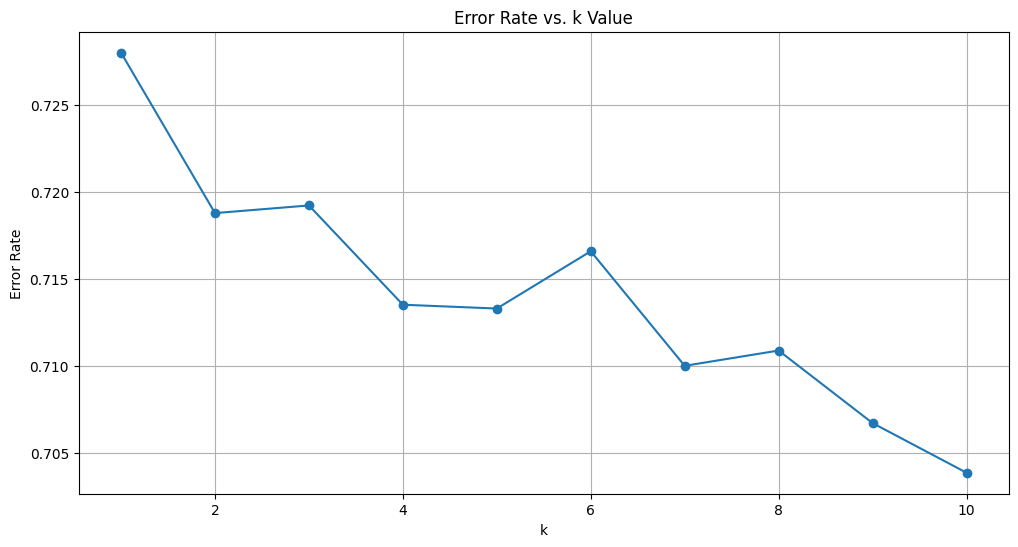

In [ ]:
# Using elbow method to determine optimal k for KNN Classification

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Choose a range of k values to test. In this case, we'll test values from 1 to
k_values = range(1, 11)

# Split data into features and label
X = modifiable_subset[['Calorie_Intake', 'Sugar_Intake', 'Physical_Activity', 'Fast_Food_Frequency', 'Screen_Time']] #add or subtract any features from list

# removed sugar intake to see if it improves accuracy
#X = modifiable_subset[['Calorie_Intake','Physical_Activity', 'Fast_Food_Frequency', 'Screen_Time']]

y = modifiable_subset[['WeightClass']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# A list to keep track of the error rates, f1-score, precision, recall for each k value.
errors = []
f1_score = []
precision = []
recall = []
accuracy = []

# Loop over k_values to train and test the KNN classifier
for k in k_values:
    # Initialize a KNN classifier with current k value.
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')

    # Train the classifier on the training data.
    knn.fit(X_train, y_train.values.ravel()) # .ravel() to flatten array to proper shape

    # Predict the labels for the test set.
    y_pred = knn.predict(X_test)

    # Calculate the error rate: 1 - accuracy.
    error = 1 - accuracy_score(y_test, y_pred)
    errors.append(error)

    # classification report to calculate f1 score at each k
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_score.append(report['weighted avg']['f1-score'])
    precision.append(report['weighted avg']['precision'])
    recall.append(report['weighted avg']['recall'])

print("Max f1 score = {}; k = {}".format(np.max(f1_score).round(2), f1_score.index(np.max(f1_score))+1 ))
print("Max precision = {}; k = {}".format(np.max(precision).round(2), precision.index(np.max(precision))+1 ))
print("Max recall = {}; k = {}".format(np.max(recall).round(2), recall.index(np.max(recall))+1 ))

# Plotting Errors
# This visualization helps in understanding the relationship between k value and the error rate.
plt.figure(figsize=(12, 6))
plt.plot(k_values, errors, marker='o')
plt.title('Error Rate vs. k Value')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

[[447 306 385  51]
 [480 341 386  67]
 [518 389 494  92]
 [215 167 197  24]]
              precision    recall  f1-score   support

           0       0.27      0.38      0.31      1189
           1       0.28      0.27      0.28      1274
           2       0.34      0.33      0.33      1493
           3       0.10      0.04      0.06       603

    accuracy                           0.29      4559
   macro avg       0.25      0.25      0.25      4559
weighted avg       0.27      0.29      0.28      4559



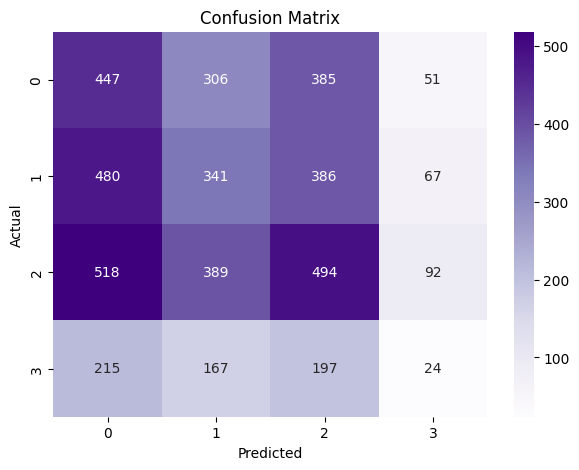

In [ ]:
## Analysis Approach 1: KNN on all four BMI Classifications

# Apply KNN
knn = KNeighborsClassifier(n_neighbors=4, metric = 'manhattan')
knn.fit(X_train, y_train.values.ravel())

# Predict using the test data
y_pred = knn.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = modifiable_subset['WeightClass'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred, labels=classes), cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<Axes: xlabel='BMI', ylabel='Age'>

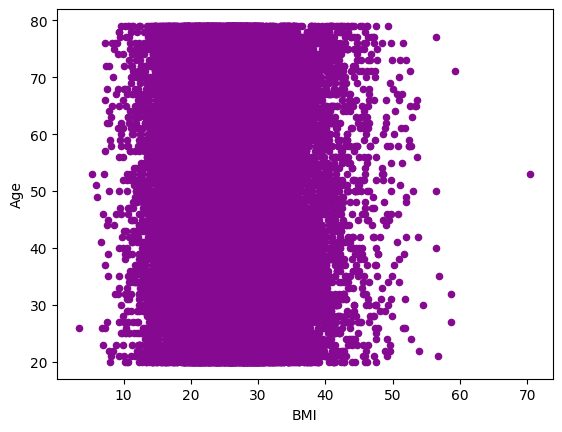

In [ ]:
# Analysis Approach 2: KMeans clustering on only obese subset

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Defining a function to visualize the results of our analysis
def plot_clusters(x, labels, k):
    colors = ['gold','seagreen', 'teal','skyblue', 'slategrey','royalblue','indigo','violet','red','peru']
    for i in range(k):
        filtered_label0 = x[labels == i]
        plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], c=colors[i])

#   DATA CLEANING

# Filtering data to only include age >= 20.
df = df.loc[(df["Age"]>=20)]

#Creating obesity category variable
df['WeightClass'] = df['BMI'].apply(assign_weight_class)

#Turning Gender into 0:Male, and 1:Female
df['Gender'].replace({'Male': 0, 'Female': 1}, inplace=True)


#   DATA VISUALIZATION
features = ['BMI', 'Age']
df[features].plot.scatter(x=features[0], y=features[1], color='#860991')
#plt.show()

Text(0.5, 1.0, 'Distribution of Weight Classes')

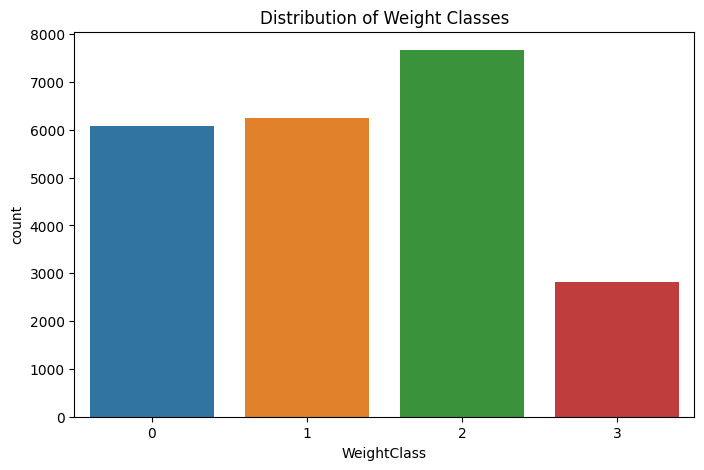

In [ ]:
# Countplot to visualize the distribution of the three species
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='WeightClass')
plt.title("Distribution of Weight Classes")
#plt.show()

In [ ]:
# Pairplot to visualize relationships between different features
sns.pairplot(df, hue='WeightClass', markers=["o", "s", "D","X"])
plt.suptitle("Pairwise Plots of Iris Features by Species", y=1.02)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

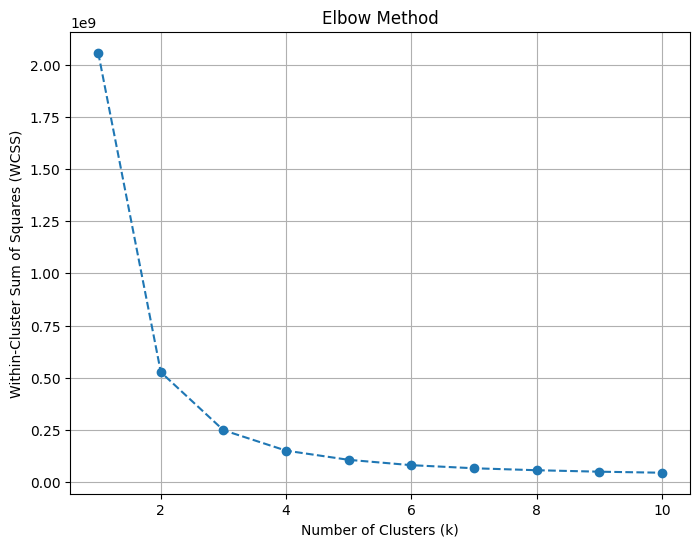

In [ ]:
#   CLUSTERING OBESITY SUBTYPES
df_cluster = df[df['WeightClass'] ==0] ##Subsetting to only those obese

# Feature Selection -- note: Removing weight and height for collinearity with BMI
df_cluster = df_cluster[['Calorie_Intake', 'Sugar_Intake', 'Physical_Activity', 'Fast_Food_Frequency', 'Screen_Time', 'BMI', 'Gender', 'Age']]

# Initialize an empty list to store the within-cluster sum of squares (WCSS) values
wcss = []

# Try different values of k (number of clusters)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_cluster)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values for different values of k
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster                         0            1            2            3
Calorie_Intake count  1604.000000  1501.000000  1493.000000  1474.000000
               mean   3241.889651  2247.690873  1749.519759  2744.215739
               std     147.727349   142.812685   142.791907   142.193058
               min    2993.000000  1999.000000  1500.000000  2497.000000
               25%    3115.000000  2127.000000  1631.000000  2623.000000
               50%    3235.500000  2249.000000  1751.000000  2747.000000
               75%    3370.250000  2372.000000  1871.000000  2861.000000
               max    3499.000000  2496.000000  1999.000000  2992.000000
Sugar_Intake   count  1604.000000  1501.000000  1493.000000  1474.000000
               mean     65.250000    64.168554    64.943737    66.013569
               std      31.954221    31.566801    32.322844    31.860777
               min      10.000000    10.000000    10.000000    10.000000
               25%      37.000000    36.000000    3

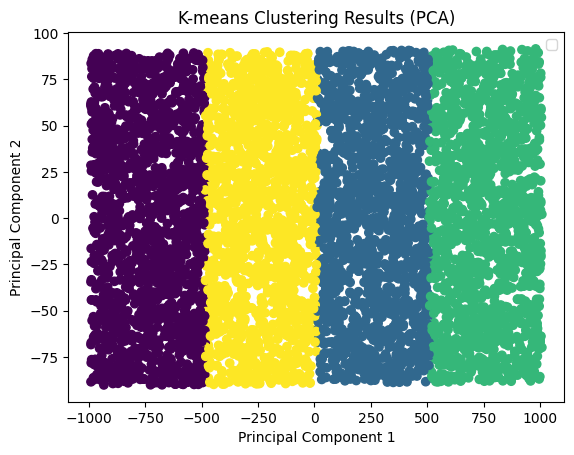

In [ ]:
#FINAL CLUSTERING MODEL

#Kmean clustering
kmeans = KMeans(n_clusters=4, random_state=42) #setting the clustering parameters
cluster_labels = kmeans.fit_predict(df_cluster) #Fitting the model to the data
cluster_centers = kmeans.cluster_centers_

#Identifying the labels of the cluster
df_cluster['Cluster'] = cluster_labels
grouped_data = df_cluster.groupby('Cluster')

#Descriptive approach to the clusters
cluster_statistics = grouped_data.describe()
cluster_statistics = cluster_statistics.transpose()
stats = pd.DataFrame(cluster_statistics)
print(stats.iloc[:16], '\n')
print(stats.iloc[16:32], '\n')
print(stats.iloc[32:], '\n')

#Plot 1:
# Reduce data to 2 principal components
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_cluster)

# Plot the reduced data with cluster colors
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Results (PCA)')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster                         0            1            2            3
Calorie_Intake count  1534.000000  1526.000000   686.000000  2326.000000
               mean   2245.353325  3243.234600  2386.011662  2235.782459
               std     429.306418   147.581215   497.470979   432.037114
               min    1500.000000  2993.000000  1506.000000  1504.000000
               25%    1868.000000  3117.250000  1989.500000  1859.250000
               50%    2242.000000  3240.500000  2368.500000  2234.000000
               75%    2622.750000  3371.000000  2794.250000  2611.750000
               max    2992.000000  3499.000000  3491.000000  2992.000000
Sugar_Intake   count  1534.000000  1526.000000   686.000000  2326.000000
               mean     64.675359    65.189384    65.758017    65.108340
               std      31.569143    31.918444    32.366781    32.051522
               min      10.000000    10.000000    10.000000    10.000000
               25%      36.000000    37.250000    3

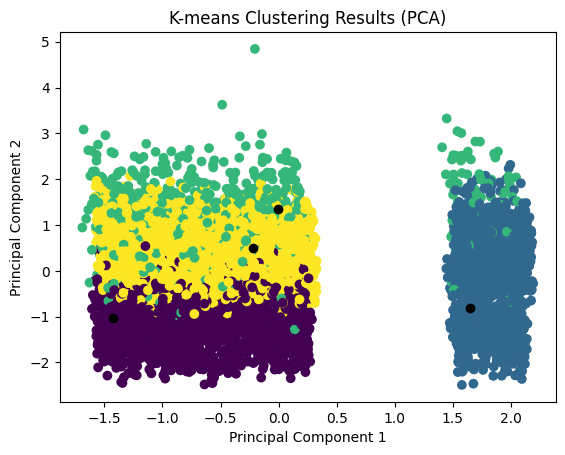

In [ ]:
#FINAL CLUSTERING MODEL - NORMALIZED

# Standardize the data - this makes the mean 0 and standard deviation 1 for each feature
# Standardization can help the k-means algorithm perform better as it's sensitive to feature scales
st_x = StandardScaler()
df_cluster_norm = st_x.fit_transform(df_cluster)

#Kmean clustering
kmeans = KMeans(n_clusters=4, random_state=42) #setting the clustering parameters
cluster_labels = kmeans.fit_predict(df_cluster_norm) #Fitting the model to the data
cluster_centers_norm = kmeans.cluster_centers_

#Identifying the labels of the cluster
df_cluster['Cluster'] = cluster_labels
grouped_data = df_cluster.groupby('Cluster')

#Descriptive approach to the clusters
cluster_statistics = grouped_data.describe()
cluster_statistics = cluster_statistics.transpose()
stats = pd.DataFrame(cluster_statistics)
print(stats.iloc[:16], '\n')
print(stats.iloc[16:32], '\n')
print(stats.iloc[32:], '\n')

#Plot 1:
# Reduce data to 2 principal components
pca = PCA(n_components=2)
reduced_data_norm = pca.fit_transform(df_cluster_norm)

# Plot the reduced data with cluster colors
plt.scatter(reduced_data_norm[:, 0], reduced_data_norm[:, 1], c=cluster_labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Results (PCA)')
plt.show()

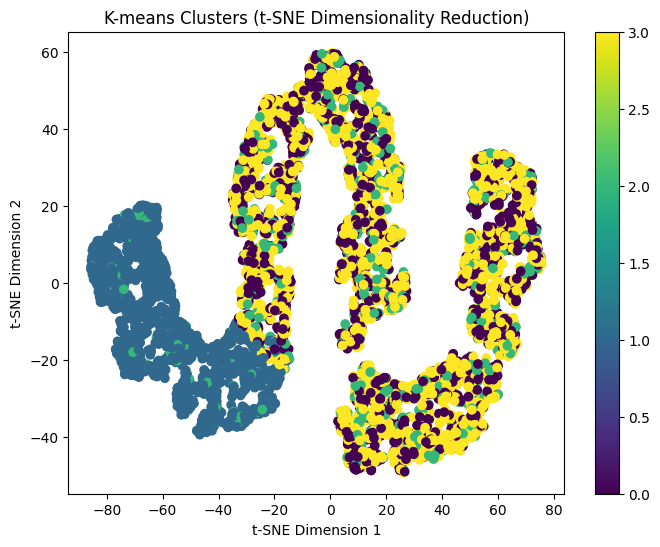

In [ ]:
#Plot 2:
tsne = TSNE(n_components=2, perplexity=40, random_state=0)
tsne_result = tsne.fit_transform(df_cluster)

# Create a scatter plot of t-SNE results colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-means Clusters (t-SNE Dimensionality Reduction)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

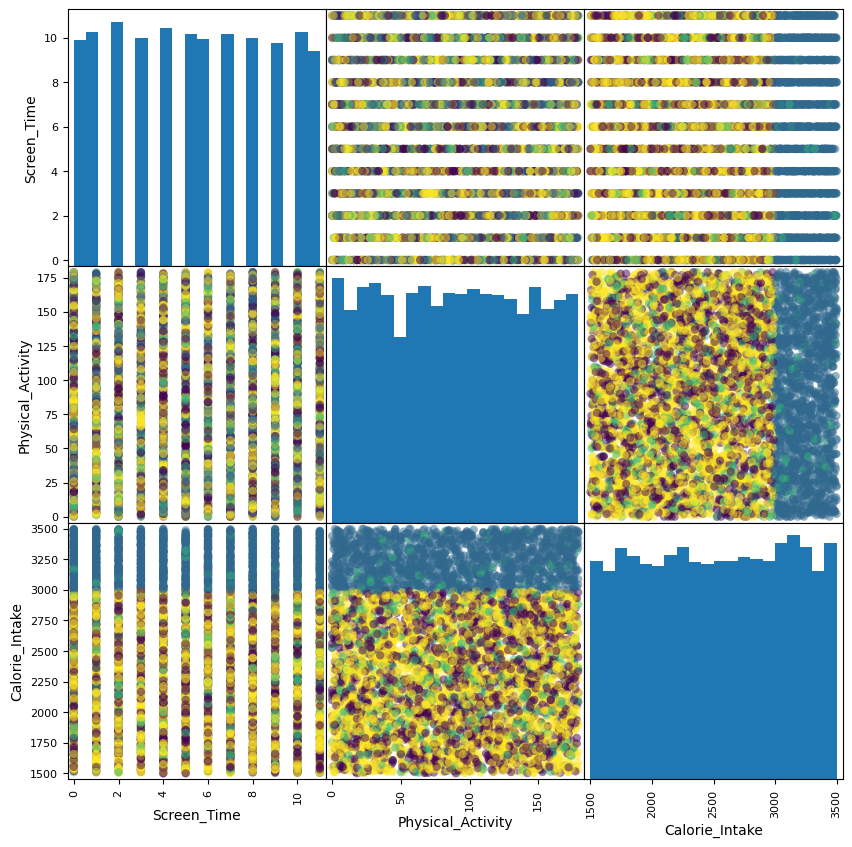

In [ ]:
#Plot 3: pairwise scatter plots
feature_subset = df_cluster[['Screen_Time', 'Physical_Activity', 'Calorie_Intake']] # Select a subset of features
scatter_matrix(feature_subset, c=cluster_labels, figsize=(10, 10), marker='o', hist_kwds={'bins': 20})
plt.show()

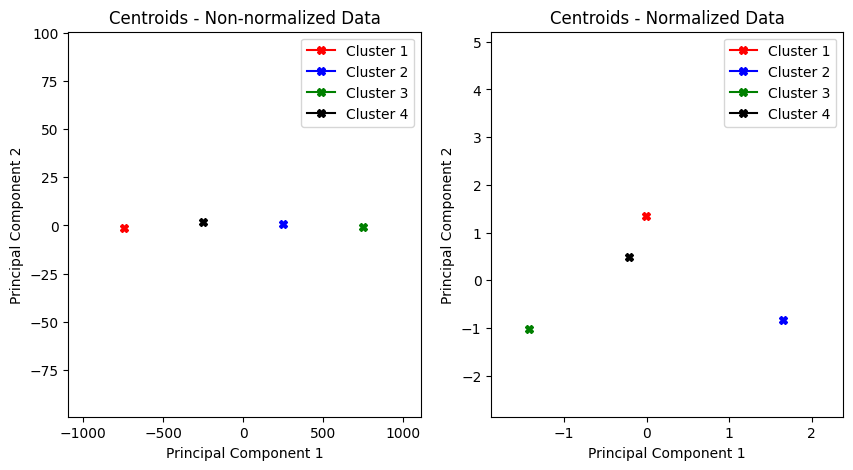

In [ ]:
# Plot 4: Comparing Non-normalized and Normalized Centroids
centroids = pca.fit_transform(cluster_centers)
centroids_norm = pca.fit_transform(cluster_centers_norm)

colors = ['red', 'blue', 'green', 'black']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,5])

ax1.scatter(reduced_data[:, 0], reduced_data[:, 1], c='white')
for i in range(4):
  ax1.plot(centroids[i,0], centroids[i,1], color=colors[i], marker = "X", label="Cluster {}".format(i+1))
ax1.set_title("Centroids - Non-normalized Data")
ax1.set_ylabel('Principal Component 2')
ax1.set_xlabel('Principal Component 1')
ax1.legend(loc='upper right')


ax2.scatter(reduced_data_norm[:, 0], reduced_data_norm[:, 1], color='white')
for i in range(4):
  ax2.plot(centroids_norm[i,0], centroids_norm[i,1], color=colors[i], marker = "X", label="Cluster {}".format(i+1))
ax2.set_title("Centroids - Normalized Data")
ax2.set_ylabel('Principal Component 2')
ax2.set_xlabel('Principal Component 1')
ax2.legend(loc='upper right')
plt.show()